### Medical Appoitment No Shown Project
(Kaggle: https://www.kaggle.com/joniarroba/noshowappointments)

In this project machine learning and data science project, I have collected the dataset from Kaggle and several ML models have been applied, in order to make prediction on wheteer a person will **show on the appointment** on not.

### Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC #Support Vector Classifier
from sklearn.tree import DecisionTreeClassifier #Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier #Random Forest Classifier
from sklearn.linear_model import LogisticRegression #Logistic Regression

import seaborn as sns

### Load data and EDA

In [2]:
df = pd.read_csv('KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.shape #we have 110527 rows and 14 columns

(110527, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


We have couple things to mention after taking a closer look on the data:
* There is **no NaN value in the dataset** which is good news
* **Patient ID** is a float **not Int**, so I will convert it to Int64
* **ScheduledDay** and **AppointmentDay** are Objects **not DateTimes**, so I will convert it to DateTime
* Typeos in column names
* We have to handle that **ScheduledDay has times (hour/minute)** while **AppointmentDay only includes T00:00:00Z**

In [5]:
#patientID to Int
df["PatientId"] = df["PatientId"].astype('int64')

#convert Objects to DateTimes
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"], format = '%Y-%m-%dT%H:%M:%SZ', errors = 'coerce')
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"], format = '%Y-%m-%dT%H:%M:%SZ', errors = 'coerce')

#correct typeos
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [6]:
#make sure all the dates are in the right format
assert df.ScheduledDay.isnull().sum() == 0, 'missing ScheduledDay dates'
assert df.AppointmentDay.isnull().sum() == 0, 'missing AppointmentDay dates'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110527 non-null  int64         
 1   AppointmentID   110527 non-null  int64         
 2   Gender          110527 non-null  object        
 3   ScheduledDay    110527 non-null  datetime64[ns]
 4   AppointmentDay  110527 non-null  datetime64[ns]
 5   Age             110527 non-null  int64         
 6   Neighbourhood   110527 non-null  object        
 7   Scholarship     110527 non-null  int64         
 8   Hypertension    110527 non-null  int64         
 9   Diabetes        110527 non-null  int64         
 10  Alcoholism      110527 non-null  int64         
 11  Handicap        110527 non-null  int64         
 12  SMSReceived     110527 non-null  int64         
 13  NoShow          110527 non-null  object        
dtypes: datetime64[ns](2), int64(9), obje

Since _PatientId_ and _AppointmentID_ are just some system generated numbers and shouldn't be used for predicting the target variable, I will remove them.

In [8]:
df.drop(["PatientId","AppointmentID"],axis=1, inplace=True)

Let's check some irregular cases, firstly the age of the patients(can't be < 0) or that the _ScheduledDay_ can't be later than the _AppointmentDay_

In [9]:
print("Patients with `Age` less than 0 -> {}".format(df[df.Age < 0].shape[0])) #we assume that this is a type so we are going to remove it
print("Patients with `Age` equal to 0 -> {}".format(df[df.Age == 0].shape[0])) #those are babies, but we will make sure

Patients with `Age` less than 0 -> 1
Patients with `Age` equal to 0 -> 3539


In [10]:
df = df[df.Age >= 0] #remove that 1 row

Most of the times babies do not have _Alcoholism_ or _Hypertension_, therefore we are going to analyze these features.

In [11]:
df[(df.Age == 0) & ((df.Hypertension.astype(int) == 1) | (df.Alcoholism.astype(int) == 1))]

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow


Since there is no any results, we can assume that our hyphothesis that those are babies are true so we are going to keep these rows.

In [12]:
(df['ScheduledDay'] > df['AppointmentDay']).sum() #there are approximately 40k appointments that were scheduled after
                                                  #the appointment day
                                                  #However, It is due to fact that all the appointment times were set at the
                                                  #earliest time (T:00:00:0Z) while times are included in ScheduledDay

38567

In [13]:
df['AppointmentDay'] = df['AppointmentDay'] + pd.Timedelta('1d')-pd.Timedelta('1s') #changing the date to (23:59:59)

In [14]:
(df['ScheduledDay'] > df['AppointmentDay']).sum() #after chaning the time only 5 rows left were the Scheduled time is after the
                                                  #appointment time, so we are going to drop these 5 rows

5

In [15]:
df = df.drop(df[df.ScheduledDay > df.AppointmentDay].index) #drop those 5 rows

In [16]:
df

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29 17:29:31,2016-04-29 23:59:59,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29 16:07:23,2016-04-29 23:59:59,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...
110522,F,2016-05-03 09:15:35,2016-06-07 23:59:59,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,F,2016-05-03 07:27:33,2016-06-07 23:59:59,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,F,2016-04-27 16:03:52,2016-06-07 23:59:59,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,F,2016-04-27 15:09:23,2016-06-07 23:59:59,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [17]:
#Adding new columns which will be created by using DateTime columns
#First - Waiitng Time in Days
df['Waiting_Time_days'] = df['AppointmentDay'] - df['ScheduledDay']
df['Waiting_Time_days'] = df['Waiting_Time_days'].dt.days

#Secondly - Day of the Week (both Schedule and Appointment day)
df['ScheduledDay_DOfW'] = df['ScheduledDay'].dt.day_name()
df['AppointmentDay_DOfW'] = df['AppointmentDay'].dt.day_name()

In [18]:
df.sample(n=10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,Waiting_Time_days,ScheduledDay_DOfW,AppointmentDay_DOfW
44996,M,2016-05-03 09:24:12,2016-05-24 23:59:59,1,SANTO ANTÔNIO,0,0,0,0,0,1,Yes,21,Tuesday,Tuesday
86552,F,2016-05-19 09:42:02,2016-06-06 23:59:59,23,DA PENHA,0,0,0,0,0,1,Yes,18,Thursday,Monday
91577,M,2016-06-08 09:52:32,2016-06-08 23:59:59,50,CONSOLAÇÃO,0,0,0,0,0,0,No,0,Wednesday,Wednesday
71633,F,2016-05-02 08:04:03,2016-05-02 23:59:59,34,BARRO VERMELHO,0,0,0,0,0,0,Yes,0,Monday,Monday
51718,F,2016-05-13 09:31:36,2016-05-20 23:59:59,70,CENTRO,0,1,0,0,0,0,No,7,Friday,Friday
50274,F,2016-04-26 17:12:33,2016-05-18 23:59:59,19,JARDIM DA PENHA,0,0,0,0,0,0,No,22,Tuesday,Wednesday
102776,F,2016-06-03 07:10:23,2016-06-07 23:59:59,44,VILA RUBIM,1,0,0,0,0,1,No,4,Friday,Tuesday
94965,F,2016-06-03 14:07:27,2016-06-03 23:59:59,48,ILHA DO PRÍNCIPE,1,1,0,0,0,0,No,0,Friday,Friday
103266,F,2016-06-08 07:47:46,2016-06-08 23:59:59,20,SANTA MARTHA,0,0,0,0,0,0,No,0,Wednesday,Wednesday
88499,M,2016-05-16 08:42:00,2016-06-03 23:59:59,7,ITARARÉ,0,0,0,0,0,1,No,18,Monday,Friday


**Check Show/NoShow ration**

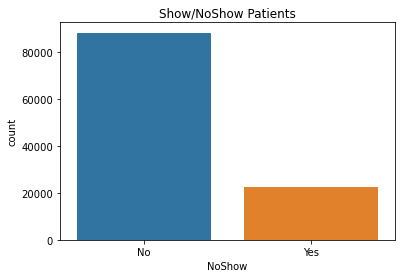

In [19]:
ax = sns.countplot(x=df.NoShow, data=df)
ax.set_title("Show/NoShow Patients")
plt.show()

**!!!IMPORTANT!!! - Clearly IMBALANCED DATASET**

**Show/NoShow ration in genders**

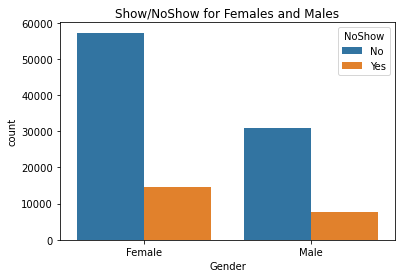

In [20]:
ax = sns.countplot(x=df.Gender, hue=df.NoShow, data=df)
ax.set_title("Show/NoShow for Females and Males")
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()

**Show/NoShow by Age**

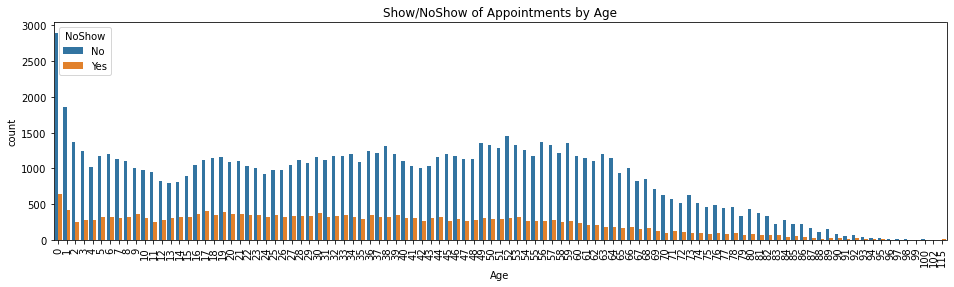

In [21]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Age, hue=df.NoShow)
ax.set_title("Show/NoShow of Appointments by Age")
plt.show()

**Show/NoShow by Neighbourhood**

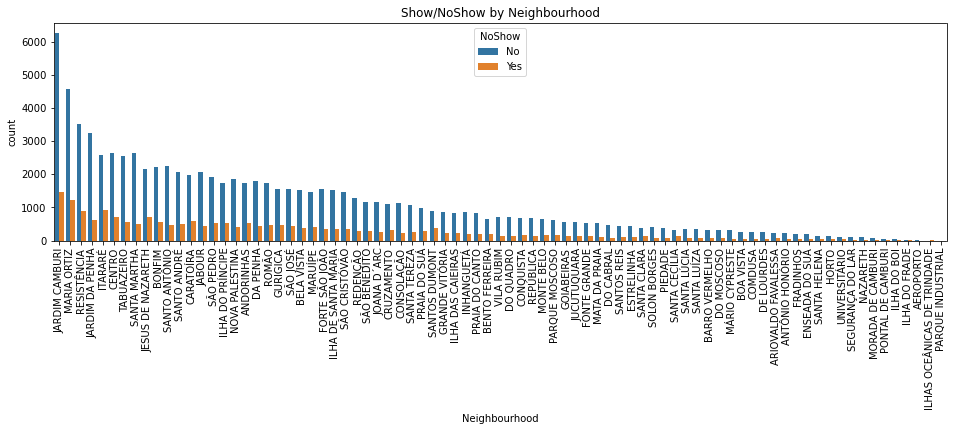

In [22]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.Neighbourhood, hue=df.NoShow, order=df.Neighbourhood.value_counts().index)
ax.set_title("Show/NoShow by Neighbourhood")
plt.show()

**Show/NoShow by DOfW** 

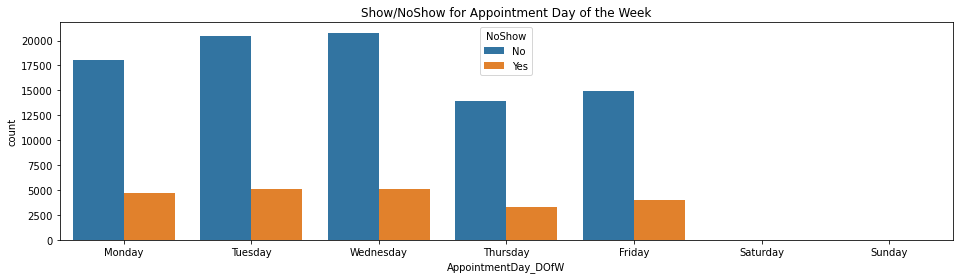

In [23]:
week_key = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.AppointmentDay_DOfW, hue=df.NoShow, order=week_key)
ax.set_title("Show/NoShow for Appointment Day of the Week")
plt.show()

**Waiting time and Show/NoShow ratio**

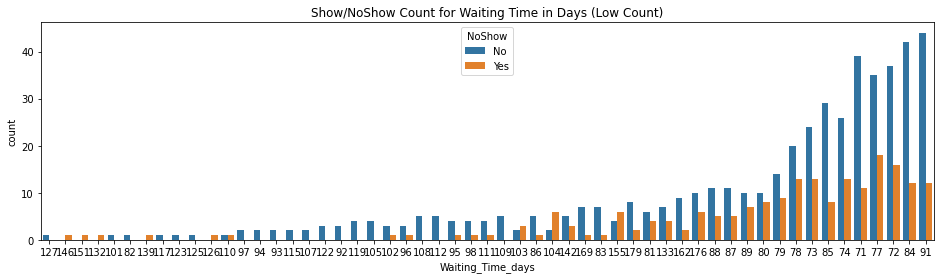

In [24]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.Waiting_Time_days, hue=df.NoShow, order=df.Waiting_Time_days.value_counts(ascending=True).iloc[:55].index)
ax.set_title("Show/NoShow Count for Waiting Time in Days (Low Count)")
plt.show()

Adding extra columns by extracting information from DateTime and after drop it.

In [25]:
df['ScheduledDay_Y'] = df['ScheduledDay'].dt.year #COMMENT - in this case year is not important because all of the data are from
                                                  #the year, but in general it can be useful
df['ScheduledDay_M'] = df['ScheduledDay'].dt.month
df['ScheduledDay_D'] = df['ScheduledDay'].dt.day
df.drop(['ScheduledDay'], axis=1, inplace=True)

df['AppointmentDay_Y'] = df['AppointmentDay'].dt.year
df['AppointmentDay_M'] = df['AppointmentDay'].dt.month
df['AppointmentDay_D'] = df['AppointmentDay'].dt.day
df.drop(['AppointmentDay'], axis=1, inplace=True)

**Target variable to Int format**

In [26]:
df['NoShow'] = (df['NoShow'] == 'Yes').astype('int')

In [27]:
df.sample(10)

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,Waiting_Time_days,ScheduledDay_DOfW,AppointmentDay_DOfW,ScheduledDay_Y,ScheduledDay_M,ScheduledDay_D,AppointmentDay_Y,AppointmentDay_M,AppointmentDay_D
40063,F,16,RESISTÊNCIA,0,0,0,0,0,0,0,0,Wednesday,Wednesday,2016,5,18,2016,5,18
87006,F,58,JARDIM CAMBURI,0,0,0,0,0,1,1,62,Tuesday,Monday,2016,4,5,2016,6,6
32378,M,3,VILA RUBIM,0,0,0,0,0,0,0,0,Tuesday,Tuesday,2016,5,31,2016,5,31
109025,F,52,BENTO FERREIRA,0,0,0,0,0,0,0,0,Friday,Friday,2016,6,3,2016,6,3
47867,F,76,DE LOURDES,0,1,1,0,0,0,0,21,Friday,Friday,2016,4,29,2016,5,20
35345,F,16,JESUS DE NAZARETH,0,0,0,0,0,0,0,0,Monday,Monday,2016,5,30,2016,5,30
19995,F,29,MÁRIO CYPRESTE,0,0,0,0,0,0,1,0,Thursday,Thursday,2016,5,19,2016,5,19
39922,F,48,DA PENHA,1,1,0,0,0,0,0,0,Monday,Monday,2016,5,30,2016,5,30
44295,F,40,ENSEADA DO SUÁ,0,0,0,0,0,1,0,30,Tuesday,Thursday,2016,4,12,2016,5,12
16145,F,33,ENSEADA DO SUÁ,0,0,0,0,0,1,1,26,Thursday,Tuesday,2016,4,28,2016,5,24


### Creating Dummy variables and Scaling features

In [28]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
#Neighbourhood
le = LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])
#ScheduledDay_DOW
le = LabelEncoder()
df['ScheduledDay_DOfW'] = le.fit_transform(df['ScheduledDay_DOfW'])
#AppointmentDay_DOW
le = LabelEncoder()
df['AppointmentDay_DOfW'] = le.fit_transform(df['AppointmentDay_DOfW'])

In [29]:
categorical_variables = ['Gender','Neighbourhood','ScheduledDay_DOfW','AppointmentDay_DOfW']
df_prep = pd.get_dummies(df,columns=categorical_variables)
df_prep.head()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,Waiting_Time_days,ScheduledDay_Y,...,ScheduledDay_DOfW_2,ScheduledDay_DOfW_3,ScheduledDay_DOfW_4,ScheduledDay_DOfW_5,AppointmentDay_DOfW_0,AppointmentDay_DOfW_1,AppointmentDay_DOfW_2,AppointmentDay_DOfW_3,AppointmentDay_DOfW_4,AppointmentDay_DOfW_5
0,62,0,1,0,0,0,0,0,0,2016,...,0,0,0,0,1,0,0,0,0,0
1,56,0,0,0,0,0,0,0,0,2016,...,0,0,0,0,1,0,0,0,0,0
2,62,0,0,0,0,0,0,0,0,2016,...,0,0,0,0,1,0,0,0,0,0
3,8,0,0,0,0,0,0,0,0,2016,...,0,0,0,0,1,0,0,0,0,0
4,56,0,1,1,0,0,0,0,0,2016,...,0,0,0,0,1,0,0,0,0,0


In [30]:
standardscaler = StandardScaler()
features_to_scale = ['Age', 'ScheduledDay_Y', 'AppointmentDay_Y']
df_prep[features_to_scale] = standardscaler.fit_transform(df_prep[features_to_scale])

In [31]:
df_prep.head()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,Waiting_Time_days,ScheduledDay_Y,...,ScheduledDay_DOfW_2,ScheduledDay_DOfW_3,ScheduledDay_DOfW_4,ScheduledDay_DOfW_5,AppointmentDay_DOfW_0,AppointmentDay_DOfW_1,AppointmentDay_DOfW_2,AppointmentDay_DOfW_3,AppointmentDay_DOfW_4,AppointmentDay_DOfW_5
0,1.077925,0,1,0,0,0,0,0,0,0.023692,...,0,0,0,0,1,0,0,0,0,0
1,0.818295,0,0,0,0,0,0,0,0,0.023692,...,0,0,0,0,1,0,0,0,0,0
2,1.077925,0,0,0,0,0,0,0,0,0.023692,...,0,0,0,0,1,0,0,0,0,0
3,-1.258748,0,0,0,0,0,0,0,0,0.023692,...,0,0,0,0,1,0,0,0,0,0
4,0.818295,0,1,1,0,0,0,0,0,0.023692,...,0,0,0,0,1,0,0,0,0,0


### Model Training

In [32]:
X = df_prep.drop('NoShow', axis=1)
y = df_prep.NoShow

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12) #splitting the data into training and test set

### 1. Decision Tree Classifier

In [33]:
dt_clf = DecisionTreeClassifier(random_state=12)
dt_clf.fit(X_train, y_train)
#print("Feature Importance:\n")
#for name, importance in zip(X.columns, np.sort(dt_clf.feature_importances_)[::-1]):
#    print("{} -- {:.2f}".format(name, importance))
dt_clf.score(X_test, y_test)

0.7358325542117803

### 2. Random Forest Classifier

In [34]:
rf_clf = RandomForestClassifier(random_state=12)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.7893657447899388

**Hyperparameter tuning with GridSearchCV**

In [35]:
n_estimators = [500, 600]
max_depth = [2, 3, 5, None]
min_samples_split = [2, 5]
min_samples_leaf = [1, 2, 4]

params_grid = {
    'n_estimators': n_estimators, 
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
              }

rf_clf = RandomForestClassifier(random_state=12)
rf_cv = GridSearchCV(rf_clf, params_grid, cv=3, verbose=1, n_jobs=-1)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 15.9min finished


Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}


RandomForestClassifier(min_samples_leaf=2, n_estimators=600)

In [37]:
rf_clf.score(X_test, y_test)

0.8028470609524384

### 3. Logistic Regression

In [36]:
lr_clf = LogisticRegression(solver='lbfgs', max_iter=5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test,y_test)

0.7932261664203637

### Conclusion

We can identify couple of limitations in the data, since information is only provided from 2016 and only few month included, therefore we can conclude that we were only given a snapshot of the complete data. Also an important thing to take into account that the time detail is missing from AppointmentDay feature.

In regard of the **imbalanced dataset**, we can see from EDA that 80% of the data represent the class who showed up, therefore a naic appoach of predicting that everyone shows up gives us a 80% accuracy. Above we can see that our trained models are approximately doing similar, however I would suggest to use another metric insted of accuracy for example **F1-score**.